# Data to Dome: How to acquire and visualize an extragalactic dataset (GAMA) in SkyExplorer from RSA Cosmos

<img src="https://raw.githubusercontent.com/IPSScienceVisualization/python-tutorials/master/images/WWTbanner.PNG">

###### This is the first of a series of tutorials on visualizing astronomical data in the planetarium created by the IPS Science and Data Visualization Task Force. It appeared in the September 2014 issue of the Planetarian, but has been updated to work with modern versions of Astropy and to include the SkyExplorer software.

This tutorial was inspired by Tanya Hill's excellent talk at the 2014 IPS conference in Beijing. In it she presented a number of surveys (including the Galaxy And Mass Assembly survey, GAMA) and described the process of importing them into SkySkan's Digital Sky software. The wealth and variety of available data was both impressive and eye-opening to a planetarium community that largely limits itself to showing three galaxy catalogs (the so-called "Tully" catalog along with the 2dF and SDSS, and most often an out of date version of the latter). At the close of the question period IPS president Thomas Kraupe declared that he would like to see these datasets made available in all planetarium systems.

That call to action is what Data to Dome is all about, how do we enable the community to become content creators?

In this tutorial we'll step through the entire process, pulling the data fom the survey database, performing astrophysical calculations and outputing the data in an Open Scene Graph format which can be visualized inside the SkyExplorer planetarium software from RSA Cosmos. I encourage everyone to at read through the entire tutorial, even the parts that apply to software packages different than the one you are running at your institution, doing so will give you a more complete picture of where the community is and help motivate the final section where we make recomendations on how the process can be made improved. 

### Python

Python is rapidly becomming the defacto astronomical programming language, supported by an active community of tool builders. Python's capabilities are extended through packages, and there are a number of good ones for dealing with astronomical data. This tutorial uses astropy which contains core astronomical functions and astroquery which lets you access astronomical databases from within the python environment. We also give an example of using the pyWWT package to directly interact with Worldwide Telescope.

One of the challenges of working in python has always been installing all the packages needed to do your work. That has gotten much easier recently through some excellent package managers. If you are just starting out with python I strongly recommend using the Anaconda distribution from Continuum Analytics. Anaconda installs most of the packages needed for scientific computing with python (astropy is included with Anaconda, unfortunately you have to install astroquery and pyWWT yourself).

This tutorial is provided as iPython notebook. You are either reading the notebook or an html rendering of the notebook. If the latter is the case you can download the notebook itself by clicking on the icon in the upper right corner of the webpage.

### Let's get started - Step #1 Acquiring the GAMA Data from the database

We want to get our galaxy catalog from the GAMA survey, to do that we need to query its database. A survey database typically contains several different tables each measuring a number of different quantities. Looking at the structure of the GAMA database (its schema) I see that the quantities I need to locate the galaxies in 3D space can be found in a table called specObj. These are sky position (RA and dec) and the redshift(z) which we will use to calculate the distance to the galaxy. There is another table called StellarMasses which has several interesting parameters, we will get three that might be useful to visualize later. There are the mass of the galaxy (logmstar), its instrinsic brightness (absMag_r) and its metalicity (metal).

The database can be accessed using the Structured Query Language(SQL). SQL has a SELECT/FROM/WHERE format, after SELECT you list what parameters you want to pull from the dataase, after WHERE you specifiy which database tables they are located in, and after WHERE you can place conditions on which objects you wish to get back.

So our query will be:

SELECT SpecObj.ra, SpecObj.dec, SpecObj.z,StellarMasses.logmstar, StellarMasses.metal, StellarMasses.absMag_r<br>
FROM SpecObj JOIN StellarMasses ON SpecObj.CATAID = StellarMasses.CATAID<br>
WHERE  SpecObj.nq>2 and SpecObj.prob >0.75<br>

The purpose of the JOIN syntax in the FROM clause is to make sure we are looking at the same galaxies in each table. The conditions in the WHERE clause make sure that the galaxies spectrum was high quality and that the redshift was certain.

Using the <a href="http://astroquery.readthedocs.org/en/latest/#">astroquery module</a> we can query the GAMA database inside python and return the results in a data table (which in the astronomical tradition of clever nameing, I call dataTable).

In [1]:
from astroquery.gama import GAMA
from astropy.table import Table,Column
from astropy import units as u
from astropy.coordinates import ICRS, CartesianRepresentation, SkyCoord, Distance
#Acquire Data from GAMA database
dataTable = GAMA.query_sql('\
   SELECT  SpecObj.ra, SpecObj.dec, SpecObj.z,\
          StellarMasses.logmstar, StellarMasses.metal, StellarMasses.absMag_r\
   FROM SpecObj JOIN StellarMasses ON SpecObj.CATAID = StellarMasses.CATAID\
   WHERE  SpecObj.nq>2 and SpecObj.prob >0.75'\
)

### Step #2 Calculate distance to the galaxies from their redshift

To plot the galaxies in 3D space we need both the position on the sky and a distance. We will convert the redshift into a distance, but how? On cosmological scales in an expanding universe with a finite speed of light, there are several ways to measure distance. Which one should we use? People have made different choices here. Some use the lookback time distance, which is the light travel time from the galaxy multiplied by the speed of light. Others have used the luminosity distance which is the distance at which the galaxy would have its observed brightness given the inverse square law. I believe that the best choice is the co-moving distance. This distance is the one that best matches our expectation of what distance is. If we were able to stop the expansion of the universe and go and measure the distance to galaxies that is what we would get.

Yes, that does mean that you will get distances greater than 13.8 billion light years, but that is OK, really it is. If you don't believe me see the Wikipedia page about misconceptions regarding the size of the Universe.

Now to calculate the comoving distance we'll need to choose a set of Cosmological parameters. One of the really nice features of astropy is  the built in set of standard cosmologies. Here I choose the Planck13 cosmology defined <a href="http://arxiv.org/abs/1303.5076">here</a>. It just takes three lines of code to choose the cosmological parameters, calculate the distances and add a new column to the data table.


In [2]:
from astropy.cosmology import Planck13
#Calculate a new column of comoving distance to the galaxies
distCol=Column(Planck13.comoving_distance(dataTable['z']),name='comoving_distance',meta={'ucd': 'pos.distance'})
#Add that column to the data table (as the third column after ra and dec)
dataTable.add_column(distCol,2)
#Create a column of coordinate objects because it will be useful later
coordsCol=SkyCoord(dataTable['ra'],dataTable['DEC'],unit=(u.degree, u.degree),\
                   distance=Distance(dataTable['comoving_distance'],u.pc),frame='icrs')

In [1]:
dataTable

NameError: name 'dataTables' is not defined

The CoordsCol array, contains a set of positions and distances each of which looks like this:

In [7]:
coordsCol[0]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (174.006, 0.72092998, 220931793.24389234)>

### Plotting the Data
Here I am using the plotting packages matplotlib and Seaborn (the latter to make things pretty, but the plots will work without it, just remove the import)

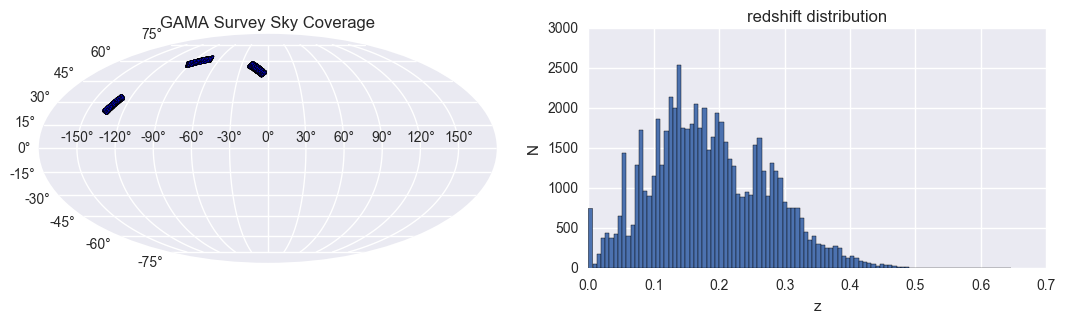

In [12]:
#Set up Matplotlib
%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
fig = plt.figure (figsize=(13,3))
ax = fig.add_subplot(121,projection="mollweide")
ax.grid(True)
ax.set_title("GAMA Survey Sky Coverage")
ax.scatter(coordsCol.galactic.l.wrap_at(180.*u.degree).radian,coordsCol.galactic.b.radian,s=1)
a2 = fig.add_subplot(122)
a2.hist(dataTable['z'],bins=100)
a2.set_title("redshift distribution")
a2.set_xlabel("z")
a2.set_ylabel("N")


## Creating the OSG file
For the SkyExplorer OSG file we want to create a table that has x,y,z cartesian coordinated in the Galactic frame expressed in meters 

In [3]:
#Now we'll add the projection into the Galactic coordinate
#minus signs convert from left-handed towards anti-center to right handed towards Galactic center coordinates [Make sure this is correct!!!]
col_x=Column(-1.0*coordsCol.galactic.represent_as(CartesianRepresentation).x.to(u.m),name='x_gal_coord',meta={'ucd': 'pos.cartesian.x'})
col_y=Column(-1.0*coordsCol.galactic.represent_as(CartesianRepresentation).y.to(u.m),name='y_gal_coord',meta={'ucd': 'pos.cartesian.y'})
col_z=Column(coordsCol.galactic.represent_as(CartesianRepresentation).z.to(u.m),name='z_gal_coord',meta={'ucd': 'pos.cartesian.z'})
GAMAtable=Table([col_x,col_y,col_z])

In [4]:
GAMAtable

x_gal_coord,y_gal_coord,z_gal_coord
m,m,m
float64,float64,float64
2.91213987308e+23,3.60235240577e+24,5.7804023742e+24
1.76121614844e+24,2.19868265984e+25,3.52736149549e+25
1.2078821976e+24,1.56684737345e+25,2.51336491653e+25
2.11064253546e+22,2.69099392219e+23,4.34398841329e+23
3.89486898343e+23,5.14951712789e+24,8.28755649654e+24
5.81355226518e+23,7.97390716279e+24,1.28549263722e+25
3.86052404915e+23,5.23231698433e+24,8.46290050231e+24
3.87137979746e+23,5.25214866545e+24,8.49552901529e+24


### Writing the OSG file

In [5]:
datasetName = 'GAMA'
datasetLength=len(GAMAtable)
headerText='\
Group {\n\
    name "'+datasetName+'"\n\
    StateSet {\n\
        GL_BLEND ON\n\
        BlendFunc {\n\
          source ONE\n\
          destination ONE\n\
        }\n\
        Depth {\n\
            writeMask FALSE\n\
        }\n\
        osgx::Program {\n\
            file "data/scene/common/shader/psc/noLight.program"\n\
        }\n\
    }\n\
    Geode {\n\
      name "'+datasetName+' geode"\n\
      nodeMask 0xffffffff\n\
      cullingActive TRUE\n\
      num_drawables 1\n\
      Geometry {\n\
        DataVariance STATIC\n\
        useDisplayList TRUE\n\
        useVertexBufferObjects FALSE\n\
        PrimitiveSets 1\n\
        {\n\
          DrawArrays POINTS 0 '+str(datasetLength-1)+'\n\
        }\n\
        VertexArray Vec3Array '+str(datasetLength)+'\n\
        {\n'
footerText='\n\
        ColorBinding OVERALL\n\
        ColorArray Vec4Array 1\n\
        {\n\
          1 1 0 1\n\
        }\n\
      }\n\
    }\n\
  }\n\
}\n'


In [6]:
#Write the osg file with header and footer
writeFile = open('GAMA.osg','a')
writeFile.write(headerText)
GAMAtable.write(writeFile,format='ascii.no_header')
writeFile.write(footerText)
writeFile.close()

### Lessons Learned

Yay - you read through till the end! Wasn't too bad, right? That is really the main lesson of all of this. Tools like python and astropy make the whole process of getting, manipulating and visualizing data MUCH easier than it was before. OK, now that we've stepped through things with  GAMA go try it on another dataset.

Still there are a few recomendations for vendors to make things even smoother.<br>
1. Include support for VOtables including the parsing of UCDs. This is an astronomical standard, planetarium software should support it.<br>
2. Accept speherical as well as cartesian coordinates. Astronomical observations occur in spherical coordinates. Converting to Cartesian is an extra step that could easily be done by the computer on import.<br>
3. Accept multiple coordinate systems. It would be great to be able to import data in either Equitorial, Galactic or Ecliptic coordinates.